In [18]:
import getpass
import os

# if the API key is not set as an environment variable, prompt the user to enter it
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [19]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [21]:
import bs4
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()


# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise. Always thanks the user for the question and "
    "ask if you can help with anything else. "
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [22]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

"Task decomposition involves breaking down a complex task into smaller and simpler steps to make it more manageable for an agent or model to handle. Techniques like Chain of Thought and Tree of Thoughts help in decomposing hard tasks into multiple achievable subtasks, enhancing the model's performance on complex tasks. Task decomposition can be facilitated by providing simple prompts to guide the model in thinking step by step or by using task-specific instructions tailored to the nature of the task at hand. Thank you for your question! Is there anything else I can help you with?"

We'll need to update two things about our existing app:

`Prompt`: Update our prompt to support historical messages as an input.\
`Contextualizing questions`: Add a sub-chain that takes the latest user question and reformulates it in the context of the chat history. This can be thought of simply as building a new "history aware" retriever. We'll need to define a sub-chain that takes historical messages and the latest user question, and reformulates the question if it makes reference to any information in the historical information.

In [23]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# create_history_aware_retriever manages the case where chat_history is empty,
# and otherwise applies prompt | llm | StrOutputParser() | retriever in sequence.
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, prompt=contextualize_q_prompt
)

# The above chain prepends a rephrasing of the input query to our retriever,
# so that the retrieval incorporates the context of the conversation.


The full QA chain will simply use `history_aware_retriever` as retriever. This is needed because the queries we make to the vector databases must be precise, with all the information needed to retrieve the correct answer.

In [24]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain_2 = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain_2)

Because our chain includes a "chat_history" input, the caller needs to manage the chat history.

In [25]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

# the retriever will query the vector db with "What are typical methods used for task decomposition?"
second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Common ways of task decomposition include using techniques like Chain of Thought (CoT) to prompt models to "think step by step" and decompose hard tasks into smaller steps. Task decomposition can also be achieved through simple prompting with specific instructions like "Steps for XYZ" or "Write a story outline." Additionally, human inputs can be utilized to break down tasks into manageable subgoals. If you need more information or have any other questions, feel free to ask!


Now let's use LangGraph to handle message history. We need a persistency layer.

In [26]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


# We define a dict representing the state of the application.
# This state has the same input and output keys as `rag_chain`.
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


# We then define a simple node that runs the `rag_chain`.
# The `return` values of the node update the graph state, so here we just
# update the chat history with the input message and response.
def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }


# Our graph consists only of one node:
workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Finally, we compile the graph with a checkpointer object.
# This persists the state, in this case in memory.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [40]:
# This application out-of-the-box supports multiple conversation threads.
# We pass in a configuration dict specifying a unique identifier for a thread to control what thread is run.

config = {"configurable": {"thread_id": "andreacosta@macs.de"}}

result = app.invoke(
    {"input": "What is Task Decomposition?"},
    config=config,
)
print("Question: What is Task Decomposition?")
print(f"Answer: {result['answer']}")
print("------------------------------------------------------------------")

result = app.invoke(
    {"input": "What is one way of doing it?"},
    config=config,
)
print("Question: What is one way of doing it?")
print(f"Answer: {result['answer']}")
print("------------------------------------------------------------------")

result = app.invoke(
    {"input": "Thanks!"},
    config=config,
)
print("Question: Thanks!")
print(f"Answer: {result['answer']}")
print("------------------------------------------------------------------")

Question: What is Task Decomposition?
Answer: Task decomposition is a method used to break down complex tasks into smaller and simpler steps to make them more manageable. This technique helps in planning and executing complicated tasks more effectively by dividing them into more digestible subtasks. Task decomposition can be achieved through various methods such as prompting techniques, task-specific instructions, or human inputs.

Thank you for your question! Is there anything else I can help you with?
------------------------------------------------------------------
Question: What is one way of doing it?
Answer: One way of task decomposition is by using Large Language Models (LLMs) with simple prompting techniques. By providing prompts like "Steps for XYZ. 1." or asking questions like "What are the subgoals for achieving XYZ?", tasks can be effectively broken down into smaller components for easier management and execution.

Thank you for your question! If you have any more inquirie

In [28]:
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is a method of breaking down complex tasks into smaller and simpler steps to make them more manageable. This technique helps agents plan ahead and tackle complicated tasks more effectively by dividing them into more digestible subtasks. Task decomposition can be achieved through prompting techniques like Chain of Thought and Tree of Thoughts, or by using task-specific instructions. 

Thank you for your question! Is there anything else you would like to know?
================================ Human Message =================================

What is one way of doing it?
================================== Ai Message ==================================

One way of task decomposition is by utilizing Large Language Models (LLMs) with simple prompting techniques. For example, providing p

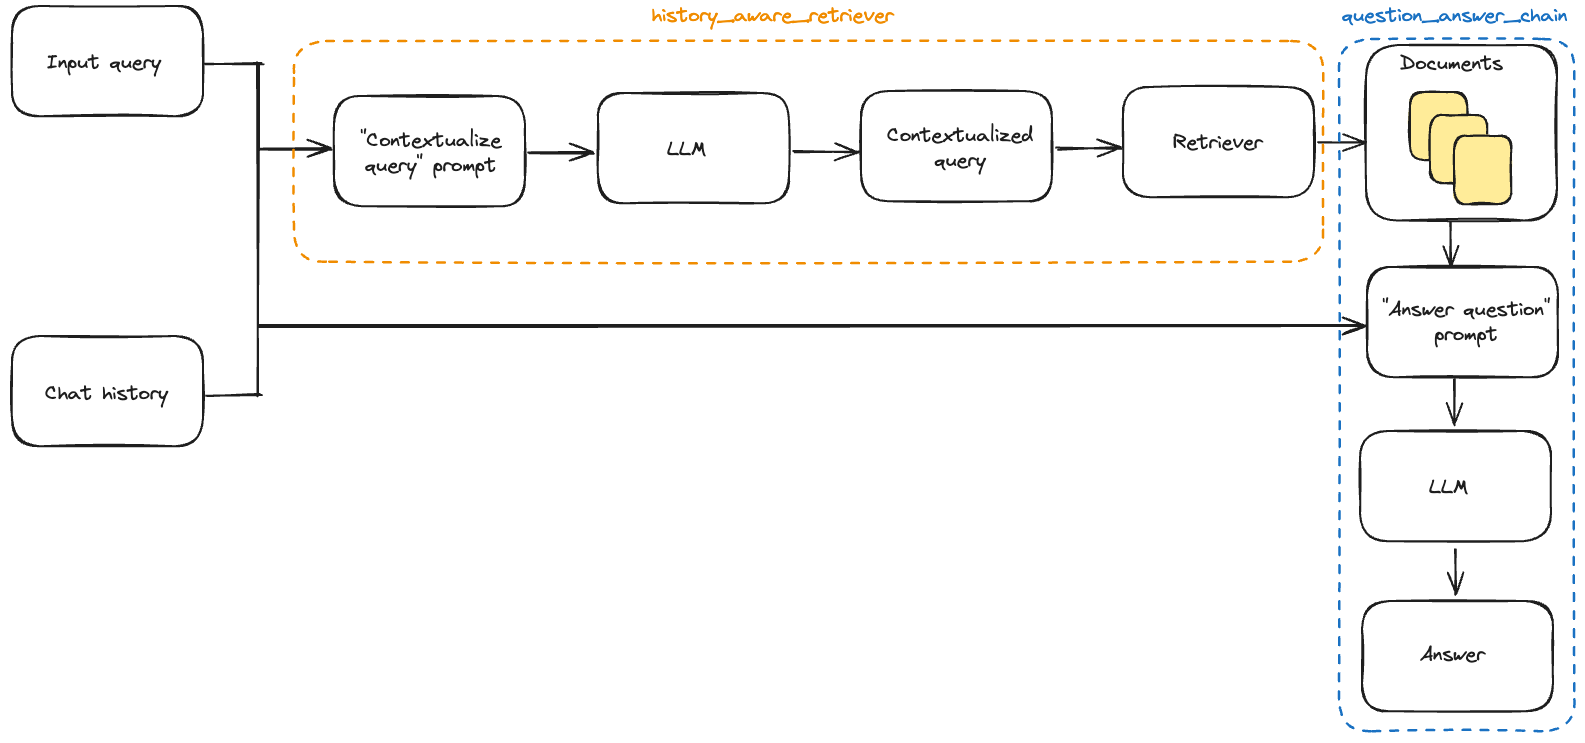

## Agents

Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allow you to offload some discretion over the retrieval process. Although their behavior is less predictable than chains, they offer some advantages in this context.

Agents generate the input to the retriever directly, without necessarily needing us to explicitly build in contextualization, as we did above.

Agents can execute multiple retrieval steps in service of a query, or refrain from executing a retrieval step altogether (e.g., in response to a generic greeting from a user).

In [29]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    name="blog_post_retriever",
    description="Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]

In [32]:
tool.invoke("task decomposition")

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The mode

In [45]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# give the agent the capability to use the retriever tool
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

In [ ]:
query = "What is Task Decomposition?"

for event in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
    config={"thread_id": "1234"},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  blog_post_retriever (call_4RxQwj0hS331FmFUiPNdvxGc)
 Call ID: call_4RxQwj0hS331FmFUiPNdvxGc
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: blog_post_retriever

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into a

In [47]:
for event in agent_executor.stream(
    {"messages": [HumanMessage(content="What are common ways of doing it?")]},
    config={"thread_id": "1234"},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  blog_post_retriever (call_SoyZ0m2kLen8XCEhkqKy21nn)
 Call ID: call_SoyZ0m2kLen8XCEhkqKy21nn
  Args:
    query: Common ways of task decomposition
================================= Tool Message =================================
Name: blog_post_retriever

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks a

In [48]:
for event in agent_executor.stream(
    {"messages": [HumanMessage(content="No thanks, I'm good.")]},
    config={"thread_id": "1234"},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No thanks, I'm good.
================================== Ai Message ==================================

You're welcome! If you have any more questions in the future, feel free to ask. Have a great day!
